# Extracting Intermediate Features Using Forward Hook

In this notebook, I will explore how to save the intermediate features. This can be achieved using the forward_hook functionality of pytorch.

### Why even extract intermediate features?

There are many situations where this is necessary. The most important application would be saving the activations and using them as an input to another model. This is especially required when it is not possible to train the whole model end-to-end. In such cases, instead of taking raw images as input, the CNN features can be used as an input to another system

### Understanding forward hooks

It is always a good idea to read the documentation as well as the source code to some extent. So here is the link for forward hook : https://pytorch.org/docs/master/nn.html#torch.nn.Module.register_forward_hook

As can be seen in the documentation we need to first define a hook function. For the `register_forward_hook`, the `hook` function takes arguments of module, input and output. The `register_forward_hook` function is called after the `forward` method of the particular module is called. The `register_forward_pre_hook` function is called just before the `forward` method of the module is called. Do note that the `hook` function in this case takes in arguments of `module` and `input` since there is no `output` yet.

As usual we will first setup our usual dogs and cats dataset which can be found here http://files.fast.ai/data/

In [1]:
import matplotlib
matplotlib.use('Agg')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "../data/dogscats/"
sz=224

In [5]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

We will use the same function used in Lec7 of Fastai course. https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-CAM.ipynb

In [6]:
class SaveFeatures:
    def __init__(self, m):
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp):
        self.features = outp
    def remove(self):
        self.handle.remove()

In [7]:
learn = ConvLearner.pretrained(arch, data)

In [8]:
mdl = learn.model

Now we will try to extract out the Features just after Adaptive Concat and just before LogSoftmax (after the final linear layer)

In [9]:
mdl

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [10]:
mdl[8]

AdaptiveConcatPool2d(
  (ap): AdaptiveAvgPool2d(output_size=(1, 1))
  (mp): AdaptiveMaxPool2d(output_size=(1, 1))
)

In [11]:
mdl[16]

Linear(in_features=512, out_features=2, bias=True)

In [12]:
sf = [SaveFeatures(m) for m in [mdl[8], mdl[16]]]

Lets first pass one image through the model and see what happens

In [13]:
x, y = next(iter(data.trn_dl))

In [14]:
img1 = x[None, 1]

In [ ]:
??data.val_ds.denorm

Denorm returns (1, 224, 224, 3) sized image, so you need img1[0] to make it (224, 224, 3)

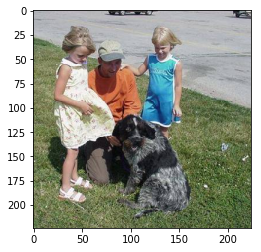

In [15]:
plt.imshow(data.val_ds.denorm(img1)[0])

This is done because the model expects the first dimension to be number of images

In [16]:
mdl(V(img1))

ValueError: Expected more than 1 value per channel when training, got input size [1, 1024]

The error message is because BatchNorm1d demands more than one image in a batch. So we turn off the batchnorm

In [17]:
mdl.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [18]:
mdl(V(img1))

Variable containing:
-0.1996 -1.7096
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

And voila we are able to pass one Image

Now lets check features of sf

In [19]:
[o.features for o in sf]

[Variable containing:
 ( 0  , 0  ,.,.) = 
    2.3408
 
 ( 0  , 1  ,.,.) = 
    4.1987
 
 ( 0  , 2  ,.,.) = 
    4.4905
       ... 
 
 ( 0  ,1021,.,.) = 
    0.4005
 
 ( 0  ,1022,.,.) = 
    0.2130
 
 ( 0  ,1023,.,.) = 
    0.2701
 [torch.cuda.FloatTensor of size 1x1024x1x1 (GPU 0)], Variable containing:
  0.7649 -0.7451
 [torch.cuda.FloatTensor of size 1x2 (GPU 0)]]

Now we will try to pass through a batch

In [20]:
mdl(V(x))

Variable containing:
-0.0260 -3.6643
-0.1996 -1.7096
-0.3913 -1.1276
-0.0377 -3.2962
-0.0119 -4.4413
-0.1598 -1.9129
-0.5270 -0.8925
-0.1464 -1.9940
-0.3721 -1.1688
-0.2462 -1.5223
-0.1152 -2.2184
-0.2079 -1.6730
-0.0267 -3.6359
-0.4900 -0.9483
-0.1919 -1.7451
-0.2416 -1.5389
-0.0408 -3.2195
-0.1390 -2.0418
-0.3435 -1.2354
-0.0338 -3.4027
-0.2295 -1.5844
-0.1226 -2.1592
-0.4791 -0.9659
-0.0453 -3.1178
-0.6423 -0.7467
-0.2744 -1.4273
-0.1698 -1.8568
-0.0190 -3.9728
-0.0850 -2.5073
-0.0927 -2.4244
-0.0246 -3.7188
-1.1070 -0.4013
-0.5783 -0.8230
-0.1630 -1.8943
-0.0300 -3.5207
-1.0593 -0.4257
-0.0762 -2.6117
-0.0227 -3.7985
-0.1235 -2.1528
-0.1522 -1.9575
-0.3046 -1.3372
-0.0329 -3.4320
-0.0553 -2.9233
-0.6634 -0.7238
-0.4273 -1.0564
-0.0907 -2.4456
-0.0812 -2.5515
-0.6884 -0.6979
-0.0724 -2.6611
-0.0240 -3.7428
-0.3734 -1.1660
-0.0382 -3.2837
-0.0415 -3.2030
-0.1009 -2.3435
-0.2540 -1.4947
-0.0520 -2.9833
-0.0533 -2.9590
-0.1014 -2.3390
-0.4906 -0.9475
-0.0256 -3.6773
-0.3972 -1.1154
-0.

In [21]:
[o.features for o in sf]

[Variable containing:
 ( 0  , 0  ,.,.) = 
    3.1685
 
 ( 0  , 1  ,.,.) = 
    6.5026
 
 ( 0  , 2  ,.,.) = 
    6.3437
       ... 
 
 ( 0  ,1021,.,.) = 
    1.1899
 
 ( 0  ,1022,.,.) = 
    0.6766
 
 ( 0  ,1023,.,.) = 
    0.8580
         ⋮  
 
 ( 1  , 0  ,.,.) = 
    2.3407
 
 ( 1  , 1  ,.,.) = 
    4.1987
 
 ( 1  , 2  ,.,.) = 
    4.4905
       ... 
 
 ( 1  ,1021,.,.) = 
    0.4005
 
 ( 1  ,1022,.,.) = 
    0.2130
 
 ( 1  ,1023,.,.) = 
    0.2701
         ⋮  
 
 ( 2  , 0  ,.,.) = 
    3.5612
 
 ( 2  , 1  ,.,.) = 
    3.7960
 
 ( 2  , 2  ,.,.) = 
    6.9056
       ... 
 
 ( 2  ,1021,.,.) = 
    1.2885
 
 ( 2  ,1022,.,.) = 
    0.5658
 
 ( 2  ,1023,.,.) = 
    0.6600
  ...      
         ⋮  
 
 ( 61 , 0  ,.,.) = 
    2.8352
 
 ( 61 , 1  ,.,.) = 
    3.7262
 
 ( 61 , 2  ,.,.) = 
    4.1206
       ... 
 
 ( 61 ,1021,.,.) = 
    0.5781
 
 ( 61 ,1022,.,.) = 
    2.0831
 
 ( 61 ,1023,.,.) = 
    0.0168
         ⋮  
 
 ( 62 , 0  ,.,.) = 
    8.2599
 
 ( 62 , 1  ,.,.) = 
    4.2843
 
 ( 62 , 

So now sf contains the features of the whole batch. 
Now we want to save all the features

This part is a bit tricky. But Fastai has an implementation which can help us. See https://github.com/fastai/fastai/blob/d5504a48d7855d59a1f1b97b746e8afd6feb4308/fastai/conv_learner.py#L174

The `save_fc1` and `get_activations` function do something close to what we want. We would need slightly different functions for our case though. Additionally we also need the function `predict_to_bcolz` defined in https://github.com/fastai/fastai/blob/a4ce954c2bda2ba9cc2a6e95ddc6b0040e217fb1/fastai/model.py#L13. So let's define them

In [ ]:
??VV

In [22]:
class FeatureSaver:
    def __init__(self, learner, tmp_path, data):
        self.learner = learner
        self.tmp_path = tmp_path
        self.m = learner.models.model
        self.sf = [SaveFeatures(m1) for m1 in [self.m[8], self.m[16]]]
        self.data = data
        self.first_step()
    
    def first_step(self):
        self.m.eval()
        x, y = next(iter(data.trn_dl))
        y = self.m(V(x))
        return
        
    def create_feat_empty_bcolz(self, nf, name):
        return bcolz.carray(np.zeros(nf, np.float32), chunklen=1, mode='w', rootdir=name)

    def get_activations_holder(self, tmpl, nf=None, force=False):
        #tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            activations = [bcolz.open(p) for p in names]
        else:
            activations = [self.create_feat_empty_bcolz(nf, n) for n in names]
        return activations

    def save_features_mdl(self, idx, tmpl):
        nf = self.sf[idx].features.shape
#         nf = len(self.sf[idx].features)
        actv = self.get_activations_holder(tmpl, nf, force=True)
        tr_act, val_act, test_act = actv
        if len(actv[0])!=len(self.data.trn_ds):
            self.predict_feat_to_bcolz(idx, self.data.fix_dl, tr_act)
        if len(actv[1])!=len(self.data.val_ds):
            self.predict_feat_to_bcolz(idx, self.data.val_dl, val_act)
        if self.data.test_dl and (len(actv[2])!=len(self.data.test_ds)):
            if self.data.test_dl: self.predict_feat_to_bcolz(idx, self.data.test_dl, test_act)


#     def predict_feat_to_bcolz(self, sf, gen, arr):
#         arr.trim(len(arr))
#         lock=threading.Lock()
#         for x,*_ in tqdm(gen):
#             y = to_np(sf)
#             with lock:
#                 arr.append(y)
#                 arr.flush()
                
    def predict_feat_to_bcolz(self, idx, gen, arr):
        arr.trim(len(arr))
        lock=threading.Lock()
        self.m.eval()
        print('Starting now')
        for x, _ in tqdm(gen):
            y = self.m(V(x))
            o1 = to_np(self.sf[idx].features)
            with lock:
                arr.append(o1)
                arr.flush()

In [23]:
tmpl = f'_{learn.models.name}_{data.sz}.bc'
feat_saver = FeatureSaver(learn, f'{PATH}tmp', data)

In [24]:
feat_saver.save_features_mdl(1, tmpl)

Starting now
100%|██████████| 360/360 [00:40<00:00,  8.82it/s]
Starting now
100%|██████████| 32/32 [00:03<00:00,  8.57it/s]


Now we want to verify if our features have been correctly saved or not

In [25]:
!ls {PATH}

models	test1  train  x_act_resnet34_0_224.bc	    x_act_val_resnet34_0_224.bc
sample	tmp    valid  x_act_test_resnet34_0_224.bc


In [26]:
x, y = data.fix_dl.dataset[1]
x1 = x[None, :]

In [27]:
mdl.eval()

mdl(to_gpu(V(x1)))

Variable containing:
-0.0585 -2.8684
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [28]:
[o.features for o in sf]

[Variable containing:
 ( 0  , 0  ,.,.) = 
    0.6602
 
 ( 0  , 1  ,.,.) = 
    3.0715
 
 ( 0  , 2  ,.,.) = 
    2.1077
       ... 
 
 ( 0  ,1021,.,.) = 
    0.0022
 
 ( 0  ,1022,.,.) = 
    1.0194
 
 ( 0  ,1023,.,.) = 
    0.6606
 [torch.cuda.FloatTensor of size 1x1024x1x1 (GPU 0)], Variable containing:
  2.1401 -0.6698
 [torch.cuda.FloatTensor of size 1x2 (GPU 0)]]

In [29]:
actvat = feat_saver.get_activations_holder(tmpl, 1, force=False)

In [30]:
tr_act, val_act, test_act = actvat

In [31]:
fcdat = ImageClassifierData.from_arrays(data.path,
                (tr_act, data.trn_y), (val_act, data.val_y), data.bs, classes=data.classes,
                test = test_act if data.test_dl else None, num_workers=8)


In [32]:
fcdat.fix_dl.dataset[1]

(array([ 2.1401 , -0.66981], dtype=float32), 0)

Voila we have recovered the correct activations!